I’m building a Titanic survival prediction model using a stacked ensemble of CatBoost, XGBoost, and Logistic Regression to improve accuracy. I handle missing values smartly (like filling Age based on passenger class and gender, and extracting Deck from Cabin). I create new features like Title, FamilySize, and IsAlone to give the model more information. After training and validating the model, I predict on the test set and save the results for Kaggle submission. I also check feature importance and visualize some key data patterns.

In [1]:
# IMPORT LIBRARIES
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

In [2]:
# LOAD DATA
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')
test_original = test.copy()  # Keep PassengerId for submission

In [3]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [4]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

HANDLING MISSING VALUES 

In [5]:
# Filling Age using median grouped by Pclass and Sex for better estimation
train['Age'] = train.groupby(['Pclass', 'Sex'])['Age'].transform(lambda x: x.fillna(x.median()))
test['Age'] = test.groupby(['Pclass', 'Sex'])['Age'].transform(lambda x: x.fillna(x.median()))

In [6]:
# Filling Embarked with mode
train['Embarked'] = train['Embarked'].fillna(train['Embarked'].mode()[0])

In [7]:
# Fill Fare with median in test set
test['Fare'] = test['Fare'].fillna(test['Fare'].median())

In [8]:
# Cabin: Extract first letter as Deck. Fill missing cabins with 'U' (Unknown)
train['Deck'] = train['Cabin'].str[0].fillna('U')
test['Deck'] = test['Cabin'].str[0].fillna('U')

**FEATURE ENGINEERING**

In [9]:
# Title Extraction from Name
train['Title'] = train['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test['Title'] = test['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

In [10]:
# Simplify Titles
for dataset in [train, test]:
    dataset['Title'] = dataset['Title'].replace(['Mlle', 'Ms'], 'Miss')
    dataset['Title'] = dataset['Title'].replace(['Mme'], 'Mrs')
    dataset['Title'] = dataset['Title'].replace(['Dr', 'Major', 'Col', 'Rev', 'Sir', 'Don', 'Capt', 'Jonkheer', 'Dona', 'Lady', 'Countess'], 'Rare')

In [11]:
# Create Family Size
for dataset in [train, test]:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

In [12]:
# IsAlone Feature
for dataset in [train, test]:
    dataset['IsAlone'] = 1  # Default to alone
    dataset['IsAlone'].loc[dataset['FamilySize'] > 1] = 0

In [13]:
# Drop unnecessary columns
drop_cols = ['Name', 'Ticket', 'Cabin']
train.drop(drop_cols, axis=1, inplace=True)
test.drop(drop_cols, axis=1, inplace=True)

**ENCODING CATEGORICAL VARIABLES**

In [14]:
# Label Encoding for simplicity
le = LabelEncoder()
for col in ['Sex', 'Embarked', 'Deck', 'Title']:
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])

**DEFINING FEATURES AND TARGET**

In [15]:
features = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Deck', 'Title', 'FamilySize', 'IsAlone']
X = train[features]
y = train['Survived']
test_X = test[features]

**TRAIN / VALIDATION SPLIT (STRATIFIED FOR BALANCE)**

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

**DEFINE BASE MODELS AND STACKING CLASSIFIER**

In [17]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
cat = CatBoostClassifier(verbose=0, random_state=42)
lr = LogisticRegression(max_iter=1000, random_state=42)

In [18]:
# Stacking: Use Logistic Regression as meta-learner
estimators = [
    ('xgb', xgb),
    ('cat', cat),
]

stack_model = StackingClassifier(
    estimators=estimators,
    final_estimator=lr,
    cv=5,
    n_jobs=-1
)

**TRAIN THE STACKED MODEL**

In [19]:
stack_model.fit(X_train, y_train)

# Validation Accuracy
y_pred = stack_model.predict(X_valid)
print("Validation Accuracy:", accuracy_score(y_valid, y_pred))

Validation Accuracy: 0.8100558659217877


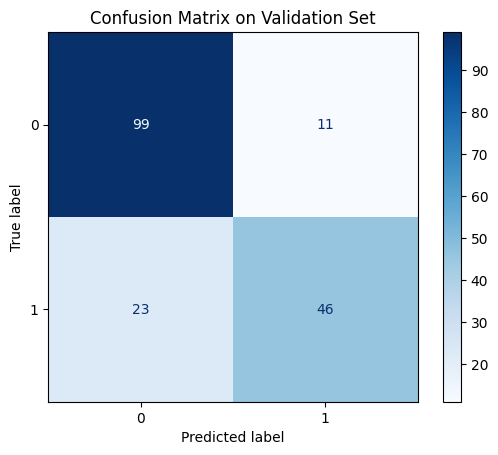

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_valid, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix on Validation Set")
plt.show()

**FINAL PREDICTION AND SUBMISSION**

In [21]:
test_pred = stack_model.predict(test_X)

submission = pd.DataFrame({
    'PassengerId': test_original['PassengerId'],
    'Survived': test_pred
})

submission.to_csv('submission.csv', index=False)
print("Submission file saved as: submission.csv")


Submission file saved as: submission.csv


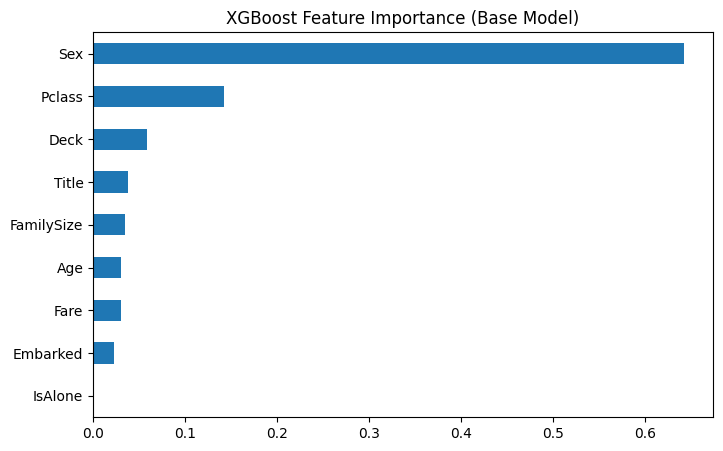

In [22]:
# Plot feature importance from XGBoost
xgb.fit(X_train, y_train)
importances = xgb.feature_importances_

feat_importances = pd.Series(importances, index=features)
feat_importances.sort_values().plot(kind='barh', figsize=(8,5))
plt.title('XGBoost Feature Importance (Base Model)')
plt.show()